In [1]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
data = pd.read_csv('ALL_data.csv', index_col='PID')
sector = pd.read_csv('Sectors.csv', index_col='PID')
data.columns

Index(['GrLivArea', 'SalePrice', 'MSSubClass', 'MSZoning', 'LotFrontage',
       'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'Pav

## Look at Sales Prices 💵

In [144]:
y = data.SalePrice.copy()

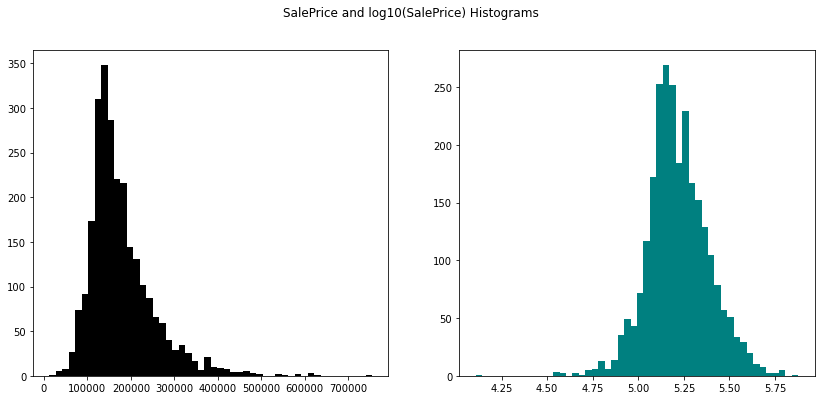

In [161]:
#Set plot size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('SalePrice and log10(SalePrice) Histograms')

ax1.hist(y, bins=50,color='k');
ax2.hist(np.log10(y), bins=50, color='teal');

## Land based features ⛰️
* MSZoning / LotArea / LotShape / LandContour / Utilities / LandSlope / Condition1 / Condition2 / Sector

In [4]:
landfeats = data[['MSZoning','LotArea','LotShape','LandContour','Utilities','LandSlope','Condition1','Condition2']].copy()

In [5]:
landfeats = landfeats.join(sector.Sector, how='left', on='PID')
landfeats = landfeats[~landfeats.index.duplicated(keep='first')] #Rows get duplicated on left_join for some reason...

**Numeric Features:** LotArea

In [6]:
landfeats.LotArea.describe()

count      2579.000000
mean      10119.269484
std        8128.389882
min        1300.000000
25%        7406.500000
50%        9382.000000
75%       11485.500000
max      215245.000000
Name: LotArea, dtype: float64

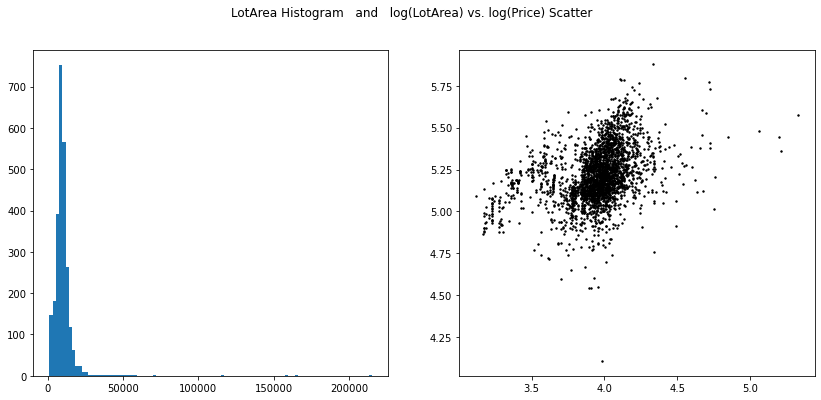

In [32]:
#Set plot size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('LotArea Histogram   and   log(LotArea) vs. log(Price) Scatter')

ax1.hist(landfeats.LotArea, bins=100)
ax2.scatter(x=np.log10(landfeats.LotArea),y=np.log10(y),s=2,c='k')

**Categorical Features:** MSZoning / LotShape / LandContour / Utilities / LandSlope / Condition1 / Condition2 / Sector

In [8]:
for col in landfeats.drop('LotArea', axis=1).columns:
    print(landfeats[col].value_counts())
    print('---------------------------')

RL         2007
RM          418
FV          113
RH           21
C (all)      17
I (all)       2
A (agr)       1
Name: MSZoning, dtype: int64
---------------------------
Reg    1640
IR1     855
IR2      71
IR3      13
Name: LotShape, dtype: int64
---------------------------
Lvl    2337
Bnk      95
HLS      95
Low      52
Name: LandContour, dtype: int64
---------------------------
AllPub    2577
NoSewr       2
Name: Utilities, dtype: int64
---------------------------
Gtl    2458
Mod     108
Sev      13
Name: LandSlope, dtype: int64
---------------------------
Norm      2227
Feedr      137
Artery      81
RRAn        40
PosN        37
RRAe        26
PosA        19
RRNn         8
RRNe         4
Name: Condition1, dtype: int64
---------------------------
Norm      2554
Feedr       12
PosN         3
PosA         3
Artery       3
RRNn         2
RRAn         1
RRAe         1
Name: Condition2, dtype: int64
---------------------------
NO    793
SW    641
NW    614
DT    393
SE    138
Name: Sector,

In [9]:
land_all = y.to_frame().merge(landfeats, on='PID')

In [10]:
land_all['MSZoning'].value_counts().index

Index(['RL', 'RM', 'FV', 'RH', 'C (all)', 'I (all)', 'A (agr)'], dtype='object')

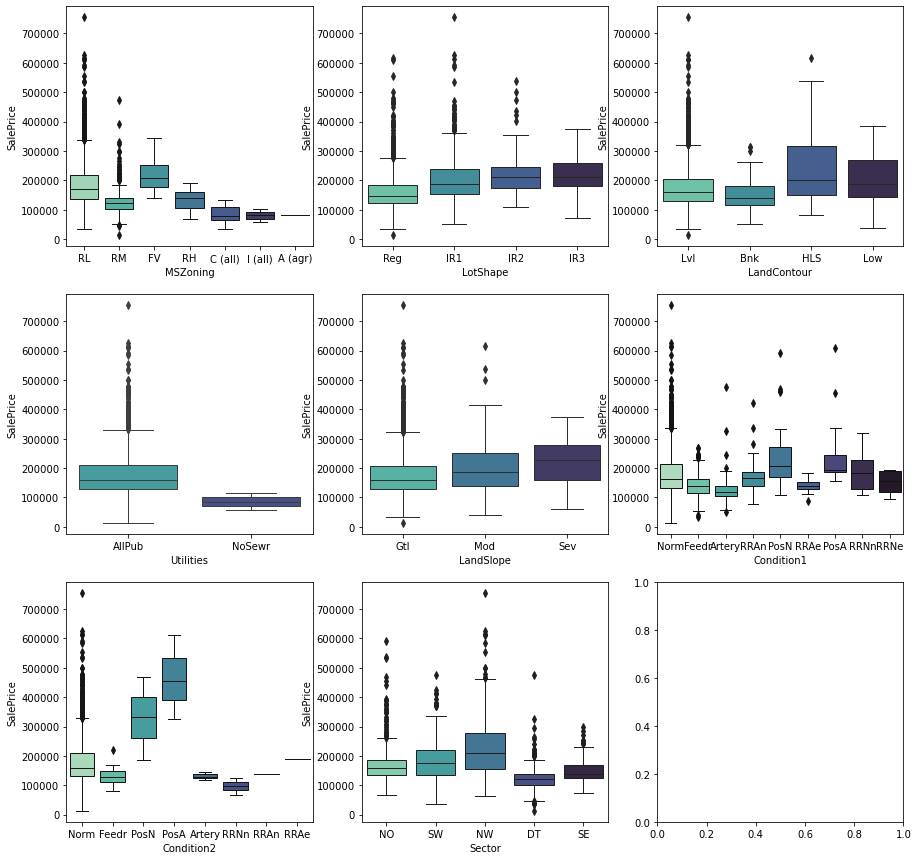

In [11]:
fig, ax = plt.subplots(3,3, figsize=(15,15))

for idx, COL in enumerate(landfeats.drop('LotArea', axis=1).columns):
    sns.boxplot(ax=ax[idx//3,idx%3],
            x=land_all[COL], y=land_all['SalePrice'], 
            order = land_all[COL].value_counts().index,
            palette="mako_r", linewidth=1)

### Findings
* LotShape and LandContour and LandSlope: may not be useful. Similar SalePrice, and concentrated in 1-2 categories
* Utilities: only 2 houses have 'No Sewer', rest are same
* Condition1 & Condition2: may be useful if a house is of PosN or PosA category, otherwise, not much use.

## Size Related Features 📐
* Columns with "SF" / "AREA"

In [328]:
size_related = data.filter(regex='SF$|Area$|(Porch)')
size_related.isnull().sum(axis=0)

GrLivArea         0
LotArea           0
MasVnrArea       14
BsmtUnfSF         1
TotalBsmtSF       1
1stFlrSF          0
2ndFlrSF          0
LowQualFinSF      0
GarageArea        1
WoodDeckSF        0
OpenPorchSF       0
EnclosedPorch     0
3SsnPorch         0
ScreenPorch       0
PoolArea          0
dtype: int64

In [329]:
size_related = size_related.fillna(0.0)  # We fill the very minor missing values by 0.0

### Create new Feature called <span style="color:blue">PorchArea</span> (Sum of all Porch & Deck)
* WoodDeckSF + OpenPorchSF + EnclosedPorch + 3SsnPorch + ScreenPorch

In [330]:
size_related['PorchArea'] = size_related[['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch']].sum(axis=1)

In [331]:
#Drop unnecessary columns
size_related.drop(['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch'],axis=1,inplace=True)

<AxesSubplot:>

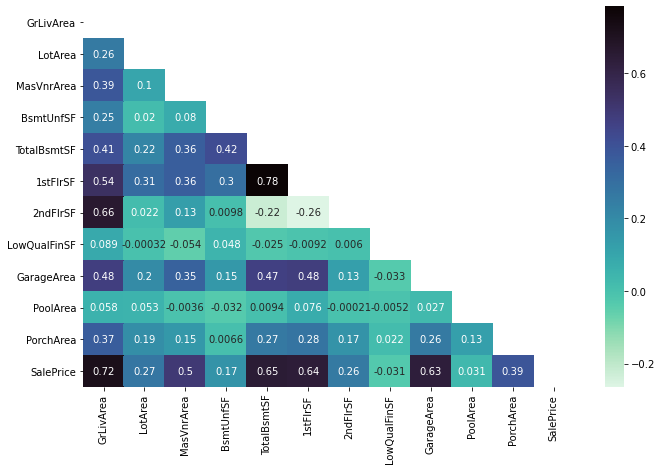

In [332]:
corr = pd.concat([size_related, y], axis=1).corr()

# Hide upper redundant heatmap
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(11, 7))
sns.heatmap(corr, mask=mask, annot=True, cmap='mako_r')

### Investigate GrLivArea (largest correlation with Sale Price 0.72)

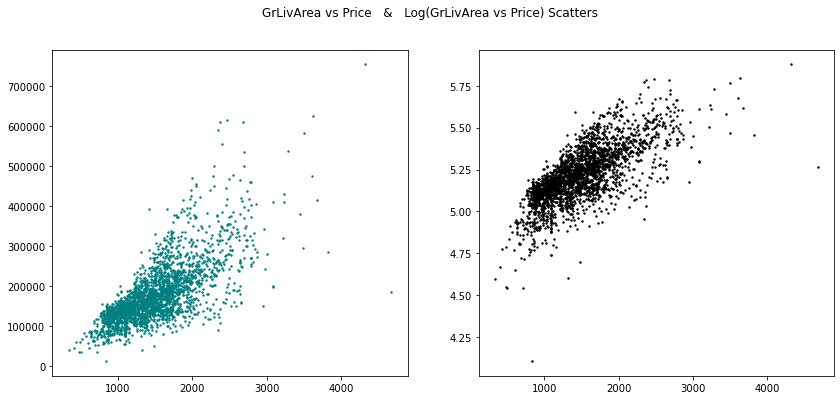

In [222]:
#Set plot size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('GrLivArea vs Price   &   Log(GrLivArea vs Price) Scatters')

ax1.scatter(x=size_related.GrLivArea,y=y,s=2,c='teal')
ax2.scatter(x=size_related.GrLivArea,y=np.log10(y),s=2,c='k')

In [33]:
# Simple Linear Regression
from sklearn.linear_model import LinearRegression

In [278]:
lm = LinearRegression()
lm.fit(np.log10(size_related[['GrLivArea']]),np.log10(y))
print(f"R2: {lm.score(np.log10(size_related[['GrLivArea']]),np.log10(y))}")
print(f'B1: {lm.coef_}')

R2: 0.5400663903547829
B1: [0.88111154]


#### Check Scatterplot for others

In [333]:
size_related.columns

Index(['GrLivArea', 'LotArea', 'MasVnrArea', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GarageArea', 'PoolArea',
       'PorchArea'],
      dtype='object')

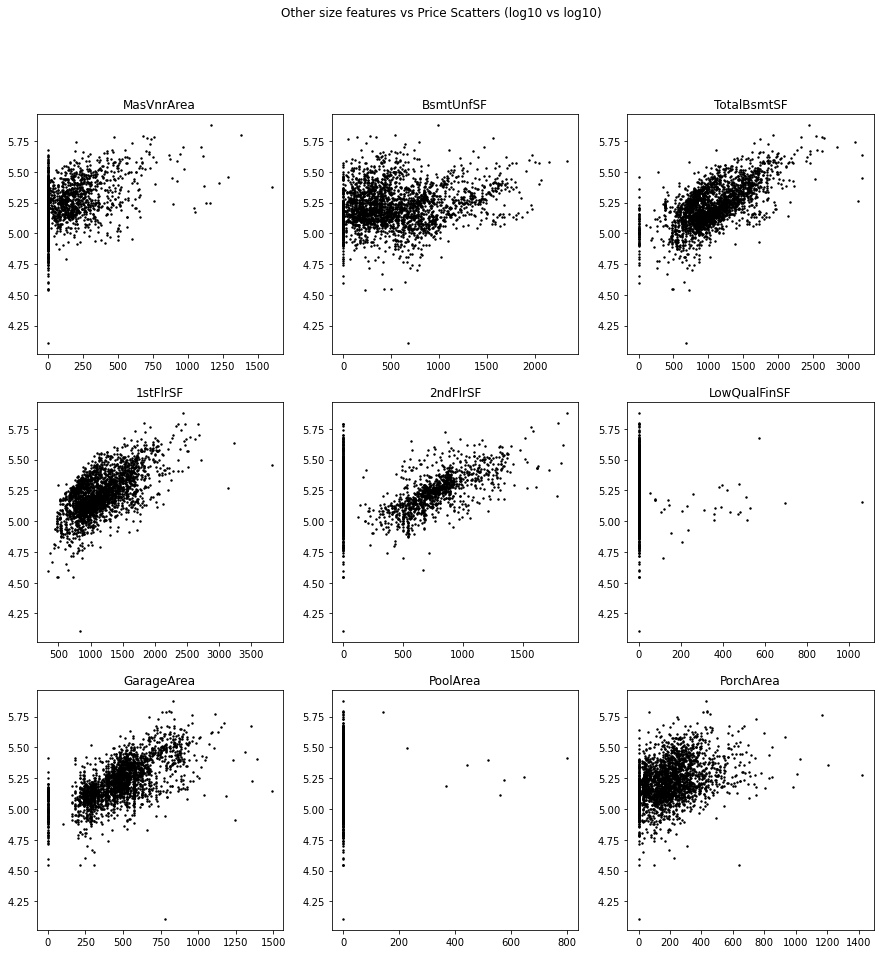

In [337]:
fig, ax = plt.subplots(3,3, figsize=(15,15))
fig.suptitle('Other size features vs Price Scatters (log10 vs log10)')

for idx, COL in enumerate(size_related.drop(['GrLivArea','LotArea'],axis=1).columns):
    ax[idx//3,idx%3].scatter(x=size_related[COL],y=np.log10(y), s=2,c='k')
    ax[idx//3,idx%3].set_title(str(COL))

#### <span style="color:blue">1stFlr, Bsmt, 2ndFlr, Garage</span> might be useful

### Create new Feature called <span style="color:blue">LBratio</span> (Land to Building Ratio)
* LotArea / 1stFlrSF

In [224]:
size_related['LBratio'] = size_related.LotArea/size_related['1stFlrSF']

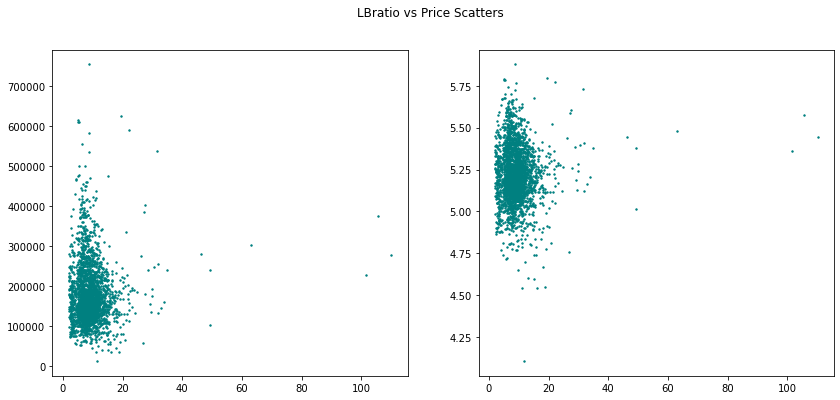

In [225]:
#Set plot size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('LBratio vs Price Scatters')

ax1.scatter(x=size_related.LBratio,y=y,s=2,c='teal')
ax2.scatter(x=size_related.LBratio,y=np.log10(y),s=2,c='teal')

#### 💩 <span style="color:red">WORTHLESS</span>, get rid of it

In [226]:
size_related.drop('LBratio',axis=1, inplace=True)

## Try Multiple Linear Regression
* Split data into Train and Test sets
* Use Lasso to select best features

#### Remove potential collinearity features
* **only Keep**: LotArea, 1stFlrSF, 2ndFlrSF, GarageArea, PorchArea

In [338]:
X = size_related[['LotArea', '1stFlrSF', '2ndFlrSF', 'GarageArea', 'PorchArea']]

In [339]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=44)

In [340]:
from sklearn.linear_model import Lasso
lasso_lm = Lasso()
lasso_lm.set_params(normalize=False)

Lasso()

In [341]:
#try different alphas
alphas = np.linspace(0.001,100,100)
coefs_lasso = []

for a in alphas:
    lasso_lm.set_params(alpha=a)
    lasso_lm.fit(X_train, np.log10(y_train))
    coefs_lasso.append(lasso_lm.coef_)

In [342]:
coefs_lasso = pd.DataFrame(coefs_lasso, index = alphas, columns = X.columns)  
coefs_lasso.head()

,LotArea,1stFlrSF,2ndFlrSF,GarageArea,PorchArea
0.001000,2.404249e-07,0.000230,0.000139,0.000279,0.000104
1.011091,4.318204e-07,0.000230,0.000136,0.000262,0.000071
2.021182,6.233048e-07,0.000229,0.000134,0.000245,0.000038
3.031273,8.147916e-07,0.000229,0.000132,0.000228,0.000005
4.041364,9.746119e-07,0.000226,0.000127,0.000209,0.000000


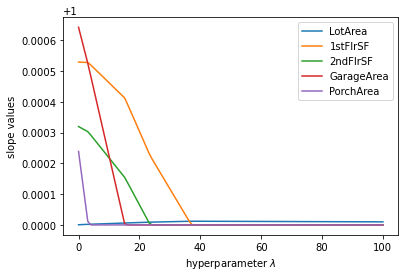

In [343]:
for name in coefs_lasso.columns:
    plt.plot(coefs_lasso.index, 10**coefs_lasso[name], label=name)
plt.xlabel(r'hyperparameter $\lambda$')
plt.ylabel(r'slope values')
plt.legend(loc=1)

#### 1stFlr and 2ndFlr are best, Maybe Garage

In [345]:
lm = LinearRegression()
lm.fit(X_train,np.log10(y_train))
lm.score(X_test,np.log10(y_test))

0.6165579769266639

In [346]:
# Check VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [347]:
vif = pd.DataFrame()
vif['var'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif

,var,VIF
0,LotArea,2.808927
1,1stFlrSF,9.666886
2,2ndFlrSF,1.753926
3,GarageArea,8.697197
4,PorchArea,2.763854


#### High VIFs (1stFlrSF and GarageArea), 
* try removing Garage

In [348]:
X = size_related[['LotArea', '1stFlrSF', '2ndFlrSF', 'PorchArea']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=44)
lm = LinearRegression()
lm.fit(X_train,np.log10(y_train))
lm.score(X_test,np.log10(y_test))

0.5781747664657413

In [349]:
vif = pd.DataFrame()
vif['var'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif

,var,VIF
0,LotArea,2.808449
1,1stFlrSF,3.990350
2,2ndFlrSF,1.514106
3,PorchArea,2.752236


### Basement info not yet utilized, create feature called <span style="color:blue">BsmtFinRatio</span> (Ratio of Finished Basement)
* (TotalBsmtSF - BsmtUnfSF) / TotalBsmtSF

In [167]:
size_related['BsmtFinRatio'] = (size_related.TotalBsmtSF - size_related.BsmtUnfSF)/size_related.TotalBsmtSF

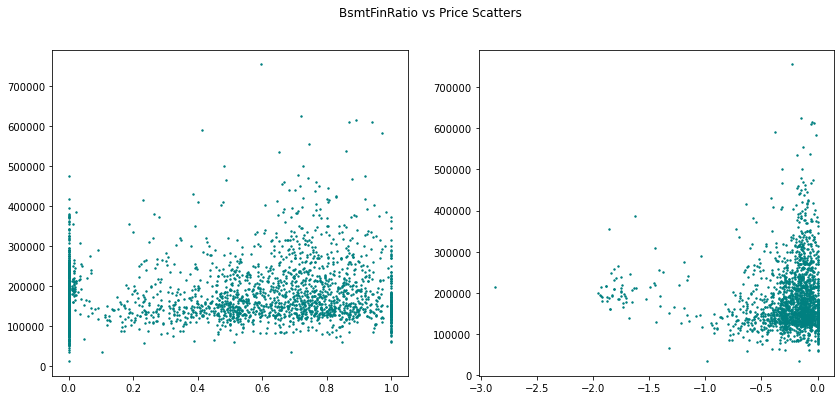

In [169]:
#Set plot size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('BsmtFinRatio vs Price Scatters')

ax1.scatter(x=size_related.BsmtFinRatio,y=y,s=2,c='teal')
ax2.scatter(x=np.log10(size_related.BsmtFinRatio),y=y,s=2,c='teal')

#### 💩 <span style="color:red">WORTHLESS</span>, get rid of it

In [170]:
size_related.drop('BsmtFinRatio',axis=1, inplace=True)

## Try turning Bsmt, Garage, Pool, DeckORPorch into <span style="color:red">BINARY</span> features (Y or N)

In [350]:
size_related.head()

,GrLivArea,LotArea,MasVnrArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GarageArea,PoolArea,PorchArea
PID,,,,,,,,,,,
526301100,1656,31770,112.0,441.0,1080.0,1656,0,0,528.0,0,272
526302030,1293,11027,28.0,171.0,1178.0,1293,0,0,452.0,0,280
526302040,1024,10533,244.0,235.0,1008.0,1024,0,0,313.0,0,280
526302110,882,13008,0.0,318.0,882.0,882,0,0,502.0,0,0
526302120,1797,11765,302.0,490.0,1617.0,1797,0,0,963.0,0,0


In [352]:
size_related['Bsmt_YN'] = size_related.TotalBsmtSF != 0
size_related['Garage_YN'] = size_related.GarageArea != 0
size_related['Pool_YN'] = size_related.PoolArea != 0
size_related['DeckPorch_YN'] = size_related.PorchArea != 0

In [353]:
X = size_related[['LotArea', '1stFlrSF', '2ndFlrSF','Bsmt_YN','Garage_YN','Pool_YN','DeckPorch_YN']]

In [354]:
#Check
X[['Bsmt_YN','Garage_YN','Pool_YN','DeckPorch_YN']].sum(axis=0)

Bsmt_YN         2510
Garage_YN       2451
Pool_YN            9
DeckPorch_YN    2147
dtype: int64

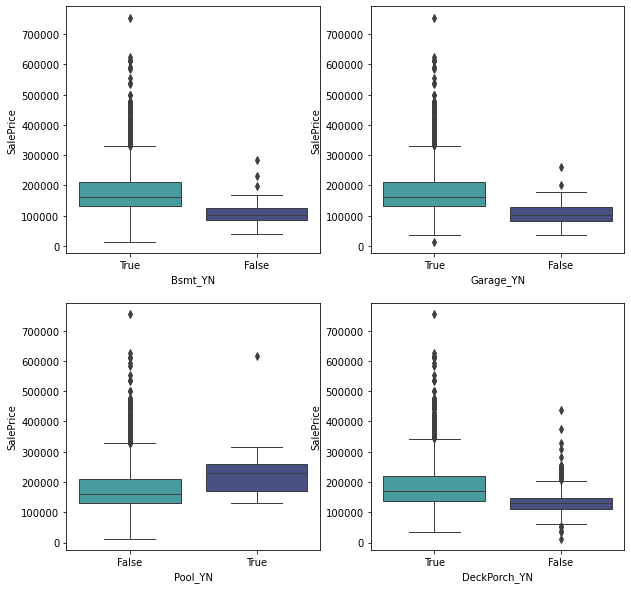

In [355]:
fig, ax = plt.subplots(2,2, figsize=(10,10))

for idx, COL in enumerate(X.drop(['LotArea', '1stFlrSF', '2ndFlrSF'], axis=1).columns):
    sns.boxplot(ax=ax[idx//2,idx%2],
            x=X[COL], y=y, 
            order = X[COL].value_counts().index,
            palette="mako_r", linewidth=1)

#### Multiple Regression with the 3 Continuous features from before plus the 4 new Binary features

In [356]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=44)
lm = LinearRegression()
lm.fit(X_train,np.log10(y_train))
lm.score(X_test,np.log10(y_test))

0.6222148441935067

* Interpret Coefficients

In [357]:
print(f'Intercept: {round(10**lm.intercept_,3)}')
pd.DataFrame(np.round(((10**lm.coef_-1)*100),3),index=X.columns)

Intercept: 31499.066


,0
LotArea,0.000
1stFlrSF,0.071
2ndFlrSF,0.039
Bsmt_YN,43.831
Garage_YN,29.968
Pool_YN,-11.944
DeckPorch_YN,12.341


#### Multiple Regression with GrLivArea plus the 4 new Binary features

In [358]:
X = size_related[['GrLivArea','Bsmt_YN','Garage_YN','Pool_YN','DeckPorch_YN']]

In [359]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=44)
lm = LinearRegression()
lm.fit(X_train,np.log10(y_train))
lm.score(X_test,np.log10(y_test))

0.5361170164195551

In [360]:
print(f'Intercept: {round(10**lm.intercept_,3)}')
pd.DataFrame(np.round(((10**lm.coef_-1)*100),3),index=X.columns)

Intercept: 37039.384


,0
GrLivArea,0.053
Bsmt_YN,39.191
Garage_YN,35.615
Pool_YN,4.433
DeckPorch_YN,12.776


#### Multiple Regression with 1st and 2nd Flr SF plus the 4 new Binary features

In [361]:
X = size_related[['1stFlrSF', '2ndFlrSF','Bsmt_YN','Garage_YN','Pool_YN','DeckPorch_YN']]

In [362]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=44)
lm = LinearRegression()
lm.fit(X_train,np.log10(y_train))
lm.score(X_test,np.log10(y_test))

0.6233449100379519

In [363]:
print(f'Intercept: {round(10**lm.intercept_,3)}')
pd.DataFrame(np.round(((10**lm.coef_-1)*100),3),index=X.columns)

Intercept: 31620.086


,0
1stFlrSF,0.072
2ndFlrSF,0.040
Bsmt_YN,43.363
Garage_YN,30.124
Pool_YN,-11.513
DeckPorch_YN,12.179
